# Evaluating Simpler Models on collected data

Because a Neural Net seems like overkill.

In [1]:
import os
import time
from datetime import date

from collections import defaultdict
from tempfile import NamedTemporaryFile
from typing import List, Tuple

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from optpresso.data.df import (
    dataframe_from_csv,
    convert_datetime_to_epoch_time,
    find_columns_to_drop,
    prepare_df_for_modeling,
)

from IPython.display import display

# On linux HistGradientBoostingRegressor can freak out with too many threads
# https://github.com/scikit-learn/scikit-learn/issues/16016
os.environ["OMP_NUM_THREADS"] = "4"

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
def convert_epoch_to_days(epoch_date):
    return epoch_date // (3600 * 24)

In [3]:
# Disable GPU, fast enough without
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
DATA_DOWNLOAD_URL = "https://docs.google.com/spreadsheets/d/1dDfuIq74pjELNtfb_0sdiNnG3qFKrfqC2sax7ewrWYg/export?format=csv"

In [4]:
df = dataframe_from_csv(DATA_DOWNLOAD_URL)
for char in [" ", "(", ")", "%", "/", "\\", '"']:
    df.columns = df.columns.str.strip().str.lower().str.replace(char, "", regex=False)
invalid_indices = df[df["time"].isna()].index
df.drop(invalid_indices, inplace=True)
df = df[pd.to_numeric(df["grindersetting"], errors="coerce").notnull()]
df["roastdate"] = pd.to_datetime(
    df.roastdate, infer_datetime_format=True, utc=True
).map(convert_datetime_to_epoch_time)
df["date"] = pd.to_datetime(df.date, infer_datetime_format=True, utc=True).map(
    convert_datetime_to_epoch_time
)
df["timesinceroast"] = convert_epoch_to_days(df["date"] - df["roastdate"])
df["grindersetting"] = df["grindersetting"].astype(np.float64)
df[["roaster", "coffee"]] = df["coffee"].str.lower().str.split("-", 1, expand=True)
df["coffee"] = df["coffee"].astype(str).replace("None", "").str.strip()
df["machineprofile"] = (
    df["machineprofile"].fillna("").replace("", "default").str.lower()
)
df["roaster"] = df["roaster"].astype(str).replace("None", "").str.strip()
df["brewratio"] = df["output"] / df["coffeegrams"]

encoded_cols = ("grinder", "coffee", "roaster", "machine", "machineprofile")

for col in find_columns_to_drop(df):
    if col in encoded_cols:
        continue
    print("Dropping", col)
    df = df.drop(col, axis=1)

encs = {}
for col in encoded_cols:
    if col not in df:
        print("No such column to encode", col)
        continue
    if len(df[col].unique()) <= 1:
        print(f"Column {col} has 1 or fewer values, not encoding")
        continue
    #     encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
    print("Encoding", col)
    encoder = OrdinalEncoder(
        handle_unknown="use_encoded_value", unknown_value=len(df[col].unique())
    )
    encoder.fit(np.asarray(df[col]).reshape(-1, 1))
    encs[col] = encoder

# Drop fields that aren't going to be encoded or are a pandas type
for field in df.columns:
    if field in encs:
        continue
    if df[field].dtype == object:
        print("Dropping", field)
        df = df.drop([field], axis=1)

for col in ["arbitraryrating1-10"]:
    if col in df.columns:
        print("Dropping", col)
        df = df.drop(col, axis=1)

Dropping timeprediction
Dropping tdsatagounfiltered
Dropping tdstempc
Encoding grinder
Encoding coffee
Encoding roaster
Encoding machine
Encoding machineprofile
Dropping details
Dropping arbitraryrating1-10


## Use distribution of grams of input coffee to enhance data

Initially values were just the grams weighed before grinding. After getting a more precise scale, data has been collected after grinding/prep, want to see if using that data can enhance the training.

In [5]:
def resample_field(
    frame, field: str, groupby: List[str], samples: int = 10, seed: int = 814
):
    to_sample = []
    state = np.random.RandomState(seed)
    # Duplicate a bunch of samples
    for name, subdf in frame.groupby(groupby):
        std = np.std(subdf[field])
        if std == 0:
            std = 0.01
        to_return = pd.concat([subdf] * samples)
        noise = state.normal(0.0, std * 0.5, size=len(to_return))
        to_return[field] = (to_return[field].values + noise).tolist()
        if field in ["coffeegrams", "output"]:
            to_return.brewratio = to_return.output / to_return.coffeegrams
        to_sample.append(to_return)
    return pd.concat(to_sample)

In [6]:
def construct_regressor(estimators: int = 125):
    return HistGradientBoostingRegressor(
        loss="poisson", max_iter=estimators, random_state=814
    )

## Evaluate using GradientBoosting to make predictions

It is feasible to build a personalized GradientBoost model, and this is to do a basic proof of concept to see if it isn't totally worthless.

In [7]:
def plot_grinder_predictions(grinder: str, prediction_field: str, y, y_pred):
    fig, (ax, ax2) = plt.subplots(ncols=2, dpi=150, figsize=(9, 4.5))
    fig.suptitle(f"{grinder}\n{prediction_field.title()}")
    ax.scatter(
        y,
        y_pred,
        marker="o",
        alpha=0.5,
    )
    lowest_point = min(np.min(y), np.min(y_pred)) - 0.25
    ax.set_title("Predictions")
    ax.set_xlabel("Experimental")
    ax.set_ylabel("Prediction")
    ax.axline([lowest_point] * 2, slope=1, color="g", linestyle="--", label="fit")
    ax.annotate(
        "mse = {:.2f}".format(mean_squared_error(y, y_pred)),
        (1.03, 0.01),
        xycoords="axes fraction",
    )
    ax.annotate(
        "mae = {:.2f}".format(mean_absolute_error(y, y_pred)),
        (1.03, 0.07),
        xycoords="axes fraction",
    )

    ax2.hist(y_pred - y, bins=30, density=True)
    ax2.set_title(f"Errors")
    ax2.set_xlabel("Error")
    ax2.set_ylabel("Density")
    fig.tight_layout()
    return fig

Prediction grindersetting
With Dropped columns: ('output', 'date', 'roastdate')


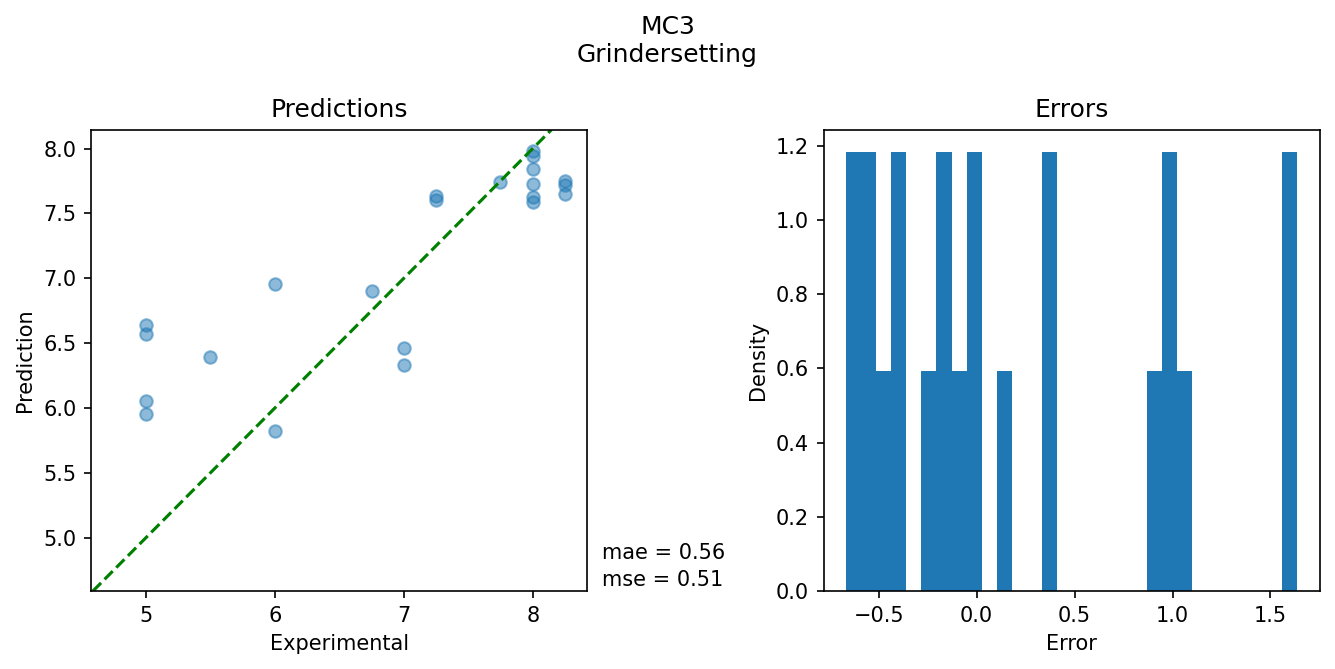

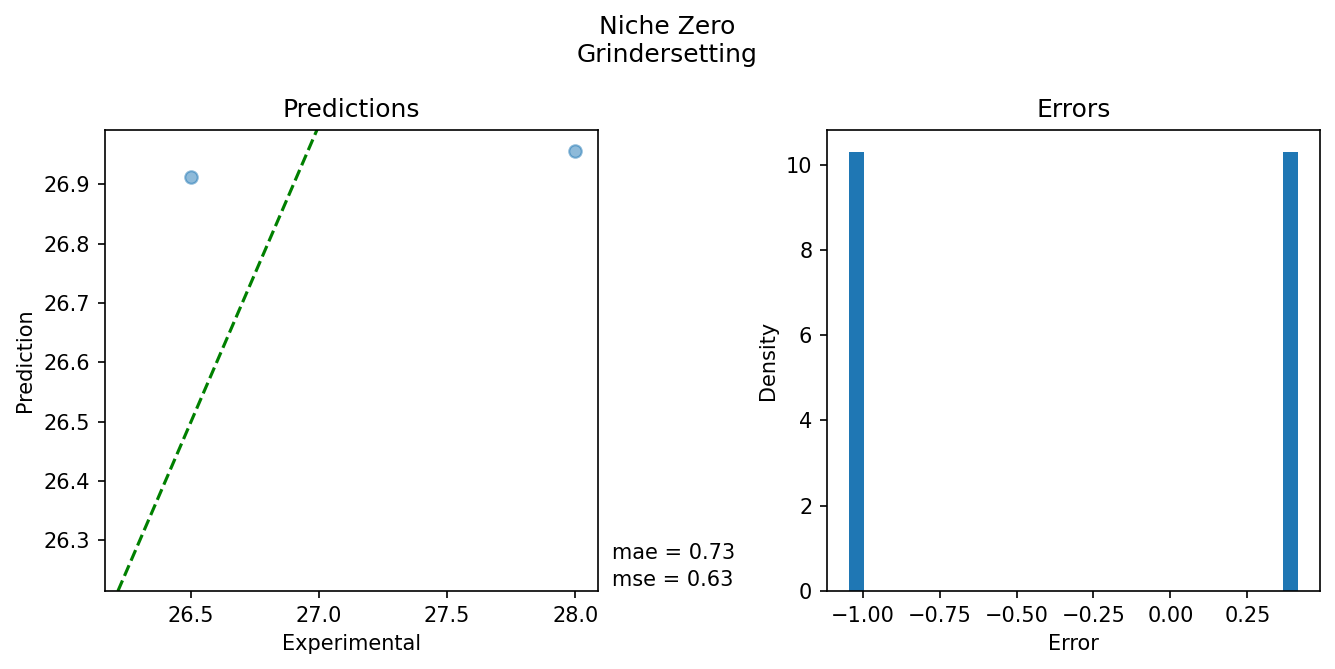

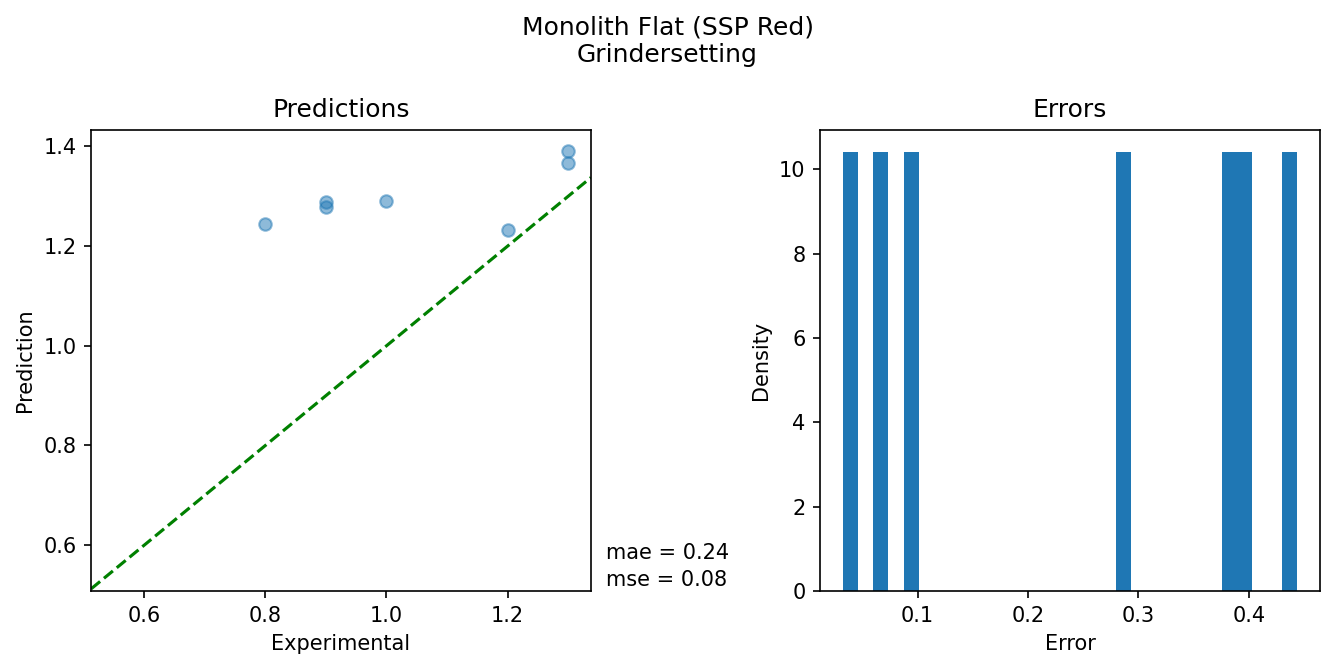

Prediction time
With Dropped columns: ('output', 'date', 'roastdate')


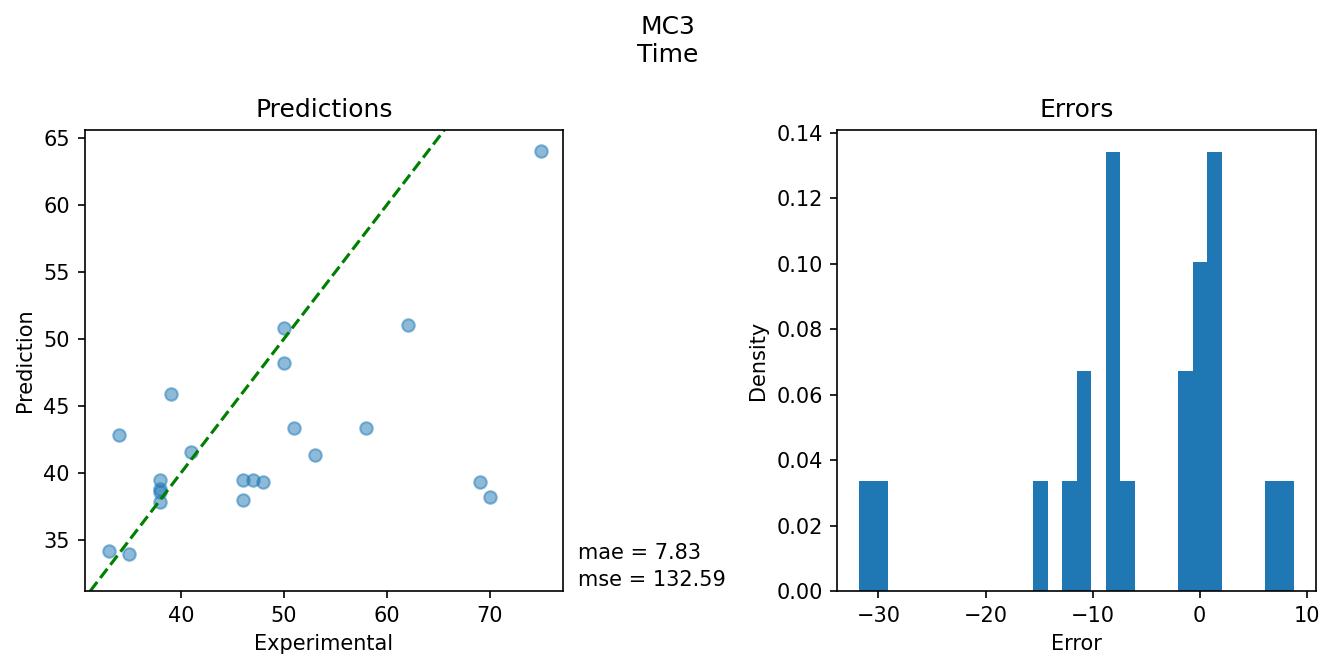

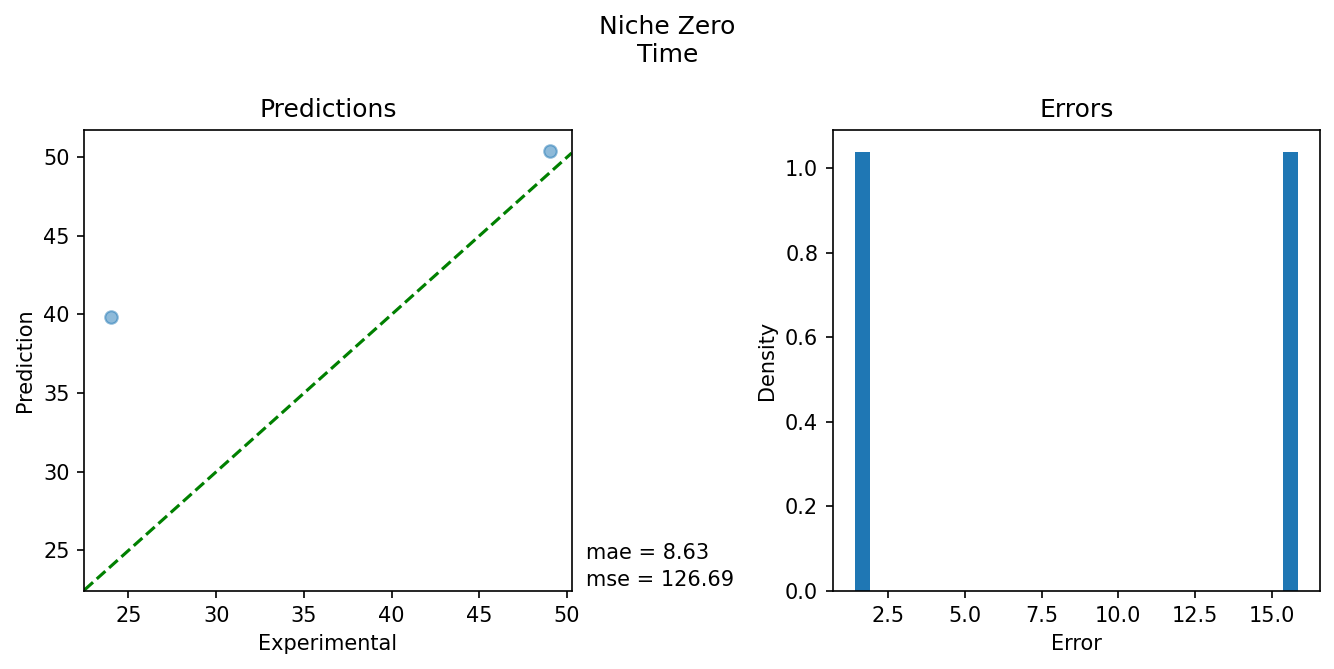

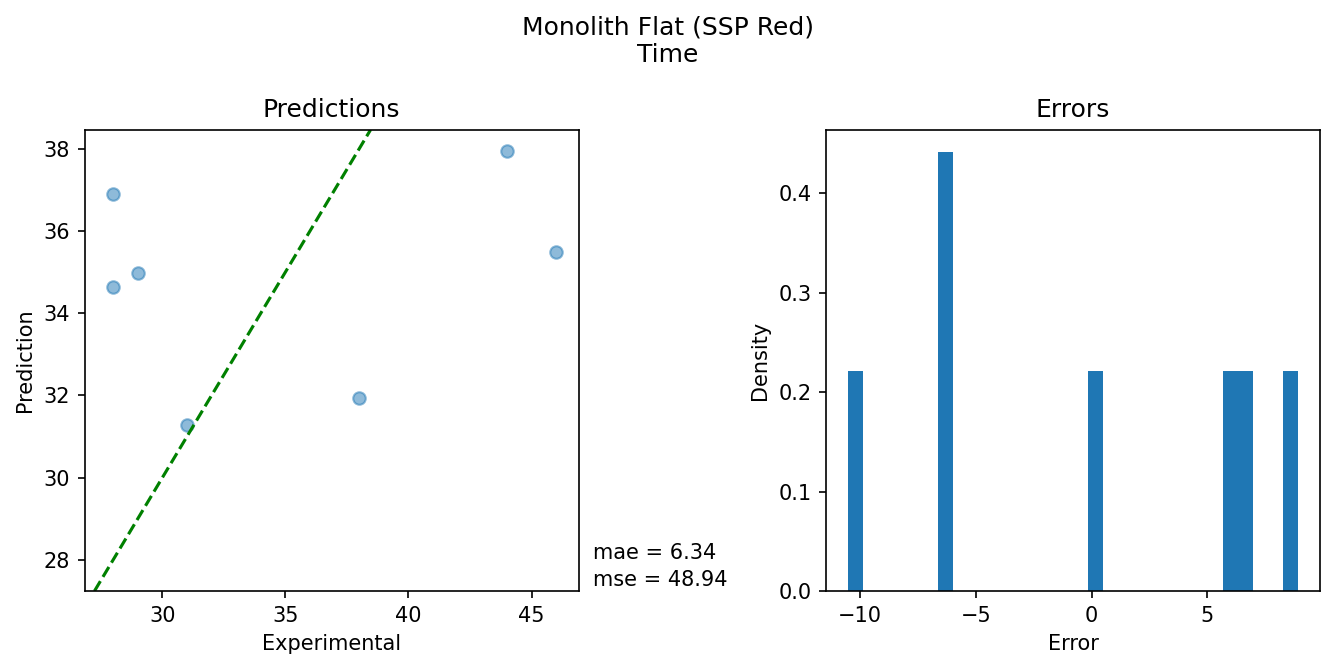

In [8]:
# Samples values for the training set
enhance_sample = True

estimators = 125
num_days = 7
days_in_seconds = 24 * 60 * 60 * num_days
data = df
latest_date = data.date.max()
# Training data is everything num_days before the most recent pull
train = data[data.date < latest_date - days_in_seconds]
test = data.drop(train.index)
if enhance_sample:
    sampled_coffee = resample_field(train, "coffeegrams", ["grinder", "coffee"])
    sampled_output = resample_field(
        train, "output", ["machine", "machineprofile", "grinder", "coffee"]
    )
    train = pd.concat([train, sampled_coffee, sampled_output])
for prediction_field in ["grindersetting", "time"]:
    print("Prediction", prediction_field)
    for dropped in [("output", "date", "roastdate")]:
        print("With Dropped columns:", dropped)
        x, y = prepare_df_for_modeling(
            train, prediction_field, drop_cols=dropped, encoders=encs
        )
        regr = construct_regressor(estimators=estimators)
        regr.fit(x, y)
        for grinder in test.grinder.unique():
            grinder_test = test[test.grinder == grinder]
            x_test, y_test = prepare_df_for_modeling(
                grinder_test, prediction_field, drop_cols=dropped, encoders=encs
            )
            yfit = regr.predict(x_test)
            plot_grinder_predictions(grinder, prediction_field, y_test, yfit)
            plt.show()

## Trying it out on new data

What happens if we throw 'novel' coffee at it, how well will it predict it across grinders?

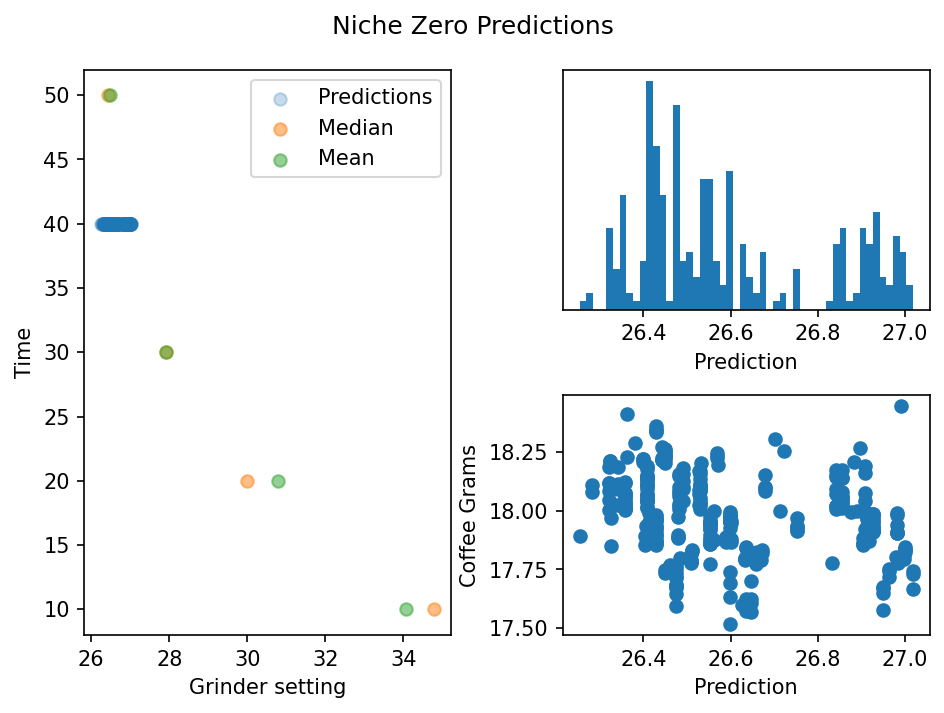

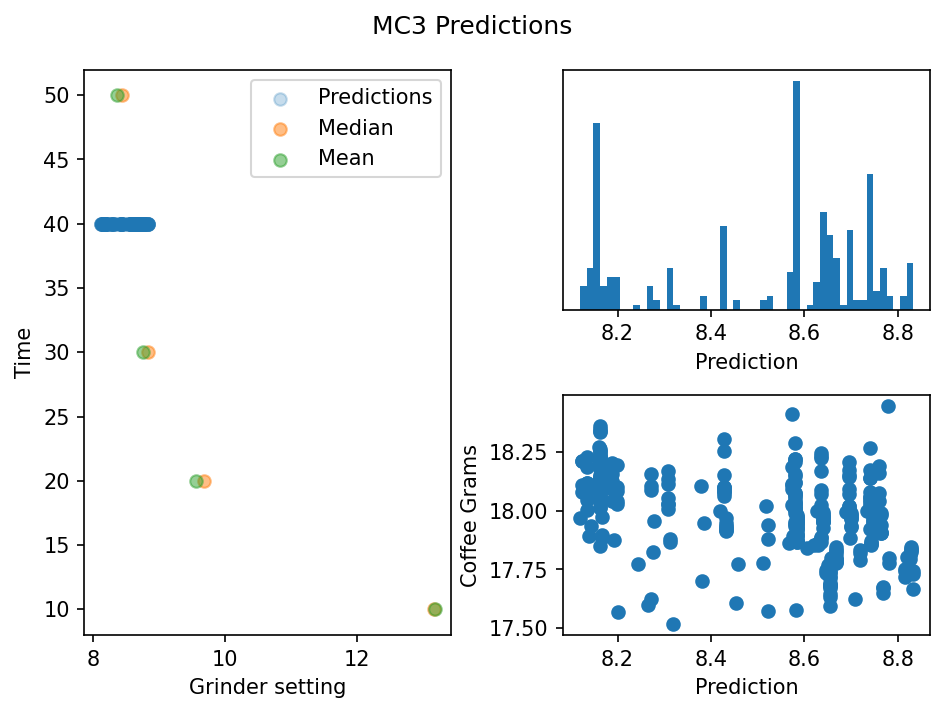

In [ ]:
dropped = ("roastdate", "date", "brewratio")
enhance_sample = True
estimators = 125

data = {
    "coffee": "Cog - Guatemala Huehuetenago 67",
    "coffeegrams": 18.0,
    "roastdate": "09/3/22",
    "time": 40,
    "brewratio": 2.0,
    "machine": "Decent DE1PRO",
    "machineprofile": "default",
    "grinder": None,  # Leave None to predict for all grinders
}
training = df
if enhance_sample:
    sampled_coffee = resample_field(training, "coffeegrams", ["grinder", "coffee"])
    sampled_output = resample_field(
        training, "output", ["machine", "machineprofile", "grinder", "coffee"]
    )
    training = pd.concat([training, sampled_coffee, sampled_output])


data["date"] = date.today().strftime("%m/%d/%Y")
data["grindersetting"] = 0.5  # Meaningless value
data["output"] = np.round(data["brewratio"] * data["coffeegrams"], 1)
test_df = pd.DataFrame.from_dict([data])
test_df[["roaster", "coffee"]] = (
    test_df["coffee"].str.lower().str.split("-", 1, expand=True)
)
test_df["coffee"] = test_df["coffee"].str.replace("None", "").str.strip()
test_df["roaster"] = test_df["roaster"].str.strip()
if test_df["roaster"].values[0] not in df.roaster.values:
    print("No matching roaster found", test_df["roaster"].values[0])
    print("-----")
if test_df["coffee"].values[0] not in df.coffee.values:
    print("No matching coffee found", test_df["coffee"].values[0])
    print("-----")
test_df.roastdate = pd.to_datetime(
    test_df.roastdate, infer_datetime_format=True, utc=True
).map(convert_datetime_to_epoch_time)
test_df.date = pd.to_datetime(test_df.date, infer_datetime_format=True, utc=True).map(
    convert_datetime_to_epoch_time
)
test_df["timesinceroast"] = convert_epoch_to_days(test_df.date - test_df.roastdate)

profile_df = df[
    (df.machine == test_df.machine.values[0])
    & (df.machineprofile == test_df.machineprofile.values[0])
]
weight_values = df.coffeegrams.unique()

max_profile_time = min(120, profile_df.time.max())
step_size = 10
min_profile_time = max(
    step_size, profile_df.time.min() - (profile_df.time.min() % step_size)
)
sample_times = list(
    range(int(min_profile_time), int(max_profile_time) + step_size, step_size)
)
prediction_time = data["time"]

x, y = prepare_df_for_modeling(
    training, "grindersetting", drop_cols=dropped, encoders=encs
)
regr = construct_regressor(estimators)
regr.fit(x, y)
for grinder in df.grinder.unique():
    if data["grinder"] is not None and data["grinder"].lower() != grinder.lower():
        continue
    test_grinder_df = test_df.copy()
    test_grinder_df = test_grinder_df.assign(grinder=[grinder])
    grinder_df = df[
        df.grinder == grinder
    ]  # & (df.machine == test_grinder_df.machine.values[0])]
    if len(grinder_df) == 0:
        continue
    fig = plt.figure(dpi=150)
    fig.suptitle(f"{grinder} Predictions")
    plot1 = fig.add_subplot(222)
    plot2 = fig.add_subplot(224)
    plot3 = fig.add_subplot(121)
    plot1.set_xlabel("Prediction")
    plot1.set_yticks([])
    plot2.set_ylabel("Coffee Grams")
    plot2.set_xlabel("Prediction")

    times = []
    med = []
    mean = []
    if prediction_time not in sample_times:
        sample_times.append(prediction_time)
    for time in sample_times:
        test_grinder_df["time"] = [time]
        x_set = [
            prepare_df_for_modeling(
                test_grinder_df, "grindersetting", drop_cols=dropped, encoders=encs
            )[0][0]
        ]
        # Look at the all the different coffeegrams values within a threshold
        for val in weight_values:
            if np.abs(data["coffeegrams"] - val) > 0.5:
                continue
            median_output = df[df.coffeegrams == val].output.median()
            if np.isnan(median_output) or np.abs(median_output - data["output"]) > 2.5:
                continue
            test_grinder_df["coffeegrams"] = [val]
            test_grinder_df["output"] = [median_output]
            test_grinder_df["brewratio"] = (
                test_grinder_df.output / test_grinder_df.coffeegrams
            )
            x_test, _ = prepare_df_for_modeling(
                test_grinder_df, "grindersetting", drop_cols=dropped, encoders=encs
            )
            x_set.append(x_test[0])
            grams_idx = np.argwhere(x_set[-1] == val).reshape(-1)
        x_set = np.array(x_set)
        yfit = regr.predict(x_set)

        if time == prediction_time:
            grams_x = x_set[:, grams_idx].reshape(-1)
            plot1.hist(yfit, bins=50, label="Predictions", density=True)
            plot2.scatter(yfit, grams_x, label="Predictions")
            if len(yfit):
                plot3.scatter(
                    yfit,
                    [time] * len(yfit),
                    label="Predictions",
                    marker="o",
                    alpha=0.25,
                )
        else:
            mean_pred = np.mean(yfit)
            med_pred = np.median(yfit)
            mean.append(mean_pred)
            med.append(med_pred)
            times.append(time)

    plot3.scatter(med, times, label="Median", alpha=0.5)
    plot3.scatter(mean, times, label="Mean", alpha=0.5)

    reference_vals = grinder_df[
        (grinder_df.coffee == test_df.coffee.values[0])
        & (grinder_df.roaster == test_df.roaster.values[0])
        & (grinder_df.roastdate == test_df.roastdate.values[0])
        & (grinder_df.machine == test_df.machine.values[0])
        & (grinder_df.grinder == grinder)
        & (grinder_df.machineprofile == test_df.machineprofile.values[0])
    ]
    if len(reference_vals):
        plot3.scatter(
            reference_vals.grindersetting,
            reference_vals.time,
            label="Reference",
            marker="x",
        )

    plot3.set_ylabel("Time")
    plot3.set_xlabel("Grinder setting")
    plot3.legend()
    fig.tight_layout()
    plt.show()